Évaluation de la CFL pour différents couples de schémas espace-temps
===

Nous nous intéressons ici à résoudre un problème de transport :

$$
  \partial_t u + \partial_x f(u) = 0
$$

Dans le cadre de l'étude de la stabilité du schéma nous ne nous intéresserons qu'au cas $f'>0$, on simplifiera même l'étude au cas où $f$ est l'identité.

La discrétisation spatiale du problème se concentrera sur le schéma WENO à l'ordre 5. Le cas du schéma WENO linéarisé a été étudié dans [[Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868)], ici nous utilisons une approche purement numérique pour étudier le cas non linéarisé du schéma, *i.e.* sa version complète. Nous nous intéresserons aussi a une variante du schéma WENO, proposée par Banks dans [[Banks J. W. and Hittinger J. A. F. (2010)](https://doi.org/10.1109/TPS.2010.2056937), [Banks J. W. et al (2019)](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf)].

Nous nous intéresserons à différentes méthodes explicites de type Runge-Kutta pour la discrétisation en temps, nous regarderons le domaine de stabilité de méthodes implicites puis nous regarderons la reformulation exponentielle d'un problème du type :

$$
  \partial_t u + Lu + N(u) = 0
$$

avec $L$ un terme linéaire, et $N$ une fonction non linéaire difficilement inversible ; ceci correspond plus au problème que nous souhaitons résoudre : Vlasov-Poisson.

In [56]:
"""
global import, and define symbols
"""

import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from IPython.display import display
sp.init_printing()

from sympy import I
#sp.init_printing(use_latex='mathjax')

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
sig      = sp.symbols("\\sigma",real=True,positive=True)
x = sp.symbols("x",real=True)

def reim(b):
  """
    function to split into 2 arrays real part and imaginary part of complex array
  """
  return ([z.real for z in b],[z.imag for z in b])

def plot(expr,x,I,*args,**kwargs):
  """
    just plot a SymPy expression `expr` of variable `x` on the interval `I`
  """
  X = np.linspace(I[0],I[1],500)
  F = sp.lambdify(x,expr,'numpy')
  plt.plot(X,F(X),*args,**kwargs)
  
class Data(object):
  """
    dummy class to store data
  """
  pass
data = Data()

# phi array to store angle where evaluate ztilde(phi)
data.phi = np.linspace(0,2.0*np.pi,10000)

# 1. Présentation du schéma WENO

Nous présenterons ici le schéma WENO d'ordre 5 dans sa configuration classique, c'est-à-dire pour estimer la dérivée spatiale $\partial_x f(u)$ :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}(\hat{f}_{j+\frac{1}{2}}-\hat{f}_{j-\frac{1}{2}})
$$

où $\hat{f}_{j+\frac{1}{2}}$ est le flux numérique de la méthode WENO.

Il est tout d'abord nécessaire de *spliter* le flux entre sa partie positive et négative :

$$
  f(u) = f^+(u) + f^-(u)
$$

de telle sorte que $\frac{df^+}{du} > 0$ et $\frac{df^-}{du} < 0$. Nous noterons par la suite $f_j^\pm$ l'approximatoin de $f^\pm(u(x_j))$ où $x_j$ est un point de la grille.

## 1.1 Schéma standard d'ordre 5

Le schéma WENO nécessite l'évaluation d'*indicator of smoothness* $IS_i$, pour évaluer les poids des 3 estimateurs ENO. Ces indicateurs sont liés à différentes approximations de dérivées d'ordre successif.

$$
  \begin{aligned}
    IS_0^+ &= \frac{13}{12}(f^+_{j-2} - 2f^+_{j-1} + f^+_{j}  )^2 + \frac{1}{4}( f^+_{j-2} - 4f^+_{j-1} + 3f^+_{j}  )^2 \\
    IS_1^+ &= \frac{13}{12}(f^+_{j-1} - 2f^+_{j}   + f^+_{j+1})^2 + \frac{1}{4}( f^+_{j-1} -  f^+_{j+1})^2 \\
    IS_2^+ &= \frac{13}{12}(f^+_{j}   - 2f^+_{j+1} + f^+_{j+2})^2 + \frac{1}{4}(3f^+_{j}   - 4f^+_{j+1} +  f^+_{j+2})^2 \\
  \end{aligned}
$$

et

$$
  \begin{aligned}
    IS_0^- &= \frac{13}{12}(f^-_{j+1} - 2f^-_{j+2} + f^-_{j+3})^2 + \frac{1}{4}(3f^-_{j+1} - 4f^-_{j+2} +  f^-_{j+3})^2 \\
    IS_1^- &= \frac{13}{12}(f^-_{j}   - 2f^-_{j+1} + f^-_{j+2})^2 + \frac{1}{4}( f^-_{j}   -  f^-_{j+2})^2 \\
    IS_2^- &= \frac{13}{12}(f^-_{j-1} - 2f^-_{j}   + f^-_{j+1})^2 + \frac{1}{4}( f^-_{j-1} - 4f^-_{j}   + 3f^-_{j+1})^2 \\
  \end{aligned}
$$

Ensuite nous calculons les poids non normalisés :

$$
  \alpha_i^\pm = \frac{\gamma_i}{\epsilon+IS_i^\pm},\quad i=0,1,2
$$

où $\epsilon$ est un paramètre numérique pour assurer la stricte positivité du dénominateur, il sera souvent pris à $10^{-6}$ ; et avec $\gamma_0 = \frac{1}{10}$, $\gamma_1 = \frac{6}{10}$ et $\gamma_2 = \frac{3}{10}$. La normalisation des poids s'effectue comme suit :

$$
  w_i^\pm = \frac{\alpha_i^\pm}{\sum_m \alpha_m^\pm},\quad i=0,1,2
$$

Nous pouvons ensuite calculer les flux numérique pour WENO5 donnés par :

$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^+   =\ & w_0^+\left( \frac{2}{6}f^+_{j-2} - \frac{7}{6}f^+_{j-1} +\frac{11}{6}f^+_{j}  \right)
                                +    w_1^+\left(-\frac{1}{6}f^+_{j-1} + \frac{5}{6}f^+_{j}   + \frac{2}{6}f^+_{j+1}\right) \\
                                +  & w_2^+\left( \frac{2}{6}f^+_{j}   + \frac{5}{6}f^+_{j+1} - \frac{1}{6}f^+_{j+2}\right)
  \end{aligned}
$$

et

$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^-   =\ & w_2^-\left(-\frac{1}{6}f^-_{j-1} + \frac{5}{6}f^-_{j}   + \frac{2}{6}f^-_{j+1}\right)
                                +    w_1^-\left( \frac{2}{6}f^-_{j}   + \frac{5}{6}f^-_{j+1} - \frac{1}{6}f^-_{j+2}\right) \\
                                +  & w_0^-\left(\frac{11}{6}f^-_{j+1} - \frac{7}{6}f^-_{j+2} + \frac{2}{6}f^-_{j+3}\right)
  \end{aligned}
$$

La méthode WENO5 prend la forme finale :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}\left[ \left(\hat{f}_{j+\frac{1}{2}}^+ - \hat{f}_{j-\frac{1}{2}}^+ \right) + \left(\hat{f}_{j+\frac{1}{2}}^- - \hat{f}_{j-\frac{1}{2}}^- \right) \right]
$$

Pour l'étude de la stabilité nous ne prendrons que le cas $f^+(u) = u$ et $f^-(u) =0$

In [3]:
"""
  fonctions pour l'aide à l'écriture du schéma WENO
"""

def f(k):
  """
    return $f_{i+k}$
  """
  if k==0:
    return sp.symbols("f_j")
  return sp.symbols("f_j%+d"%k)
  
def stencil(i_min,i_max) :
  """
    stencil
    return dictionary of (i,f_i) value between `i_min` and `i_max`
  """
  return dict(enumerate([ f(i) for i in range(i_min,i_max+1) ],start=i_min))
f_stencil = stencil(-3,3)

def symbols_to( stencil , func ):
  """
    symbols_to
    convert dictionary `stencil` of `int => sp.Symbols` to dictionary of`sp.Symbols => sp.Symbols`
    useful to replace all $f_i$ symbols by an other value in expression
  """
  r = {}
  for j,f in stencil.items():
    r[f] = func(j,f)
  return r

def symbols_to_vonNeumann( stencil ):
  """
    symbols_to_vonNeumann
    convert all $f_i$ symbols to equivalent in von Neumann analysis with exponential
    $\phi$ symbol need to be initialized
  """
  return symbols_to( stencil , lambda j,_:sp.exp(I*j*phi) )

## 1.2 WENO linéarisé

Le schéma WENO n'étant pas linéaire il n'est pas possible d'appliquer la méthode de l'analyse de von Neumann directement pour estimer un coefficient d'amplification $\lambda^W(\phi)$ dépendant uniquement de la phase $\phi$. C'est pour cela que l'analyse de stabilité s'effectue en effectuant une linéarisation du schéma WENO, le calcul complet est présenté dans [[Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868)] et repris dans [[Motamed M. and Macdonald C. B. (2010)](https://doi.org/10.1007/s10915-010-9423-9)] où est aussi effectué des approximations de CFL. La linéarisation part d'un développement limité des poids, on peut supposer notre fonction suffisamment régulière pour que les poids s'écrivent :

$$
  w_i = \gamma_i + \epsilon_i
$$

avec $\epsilon_i = \mathcal{O}(\Delta x^2)$. Le coefficient d'amplification du schéma WENO linéarisé s'écrit :

$$
  \lambda^{LW}(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i\}_i,\phi)
$$

Wang et Spiteri montrent qu'il est possible de majorer tranquillement le module de $M$ (partie non linéaire de la méthode WENO). Un développement limité en $\phi$ au voisinage de 0 (la zone où cela peut réellement poser problème) permet de démontrer la stabilité ou non d'un couple de schémas, son utilisation pour l'évaluation d'une CFL est peut-être un peu plus discutable bien que cela puisse donner une estimation facilement calcubale.

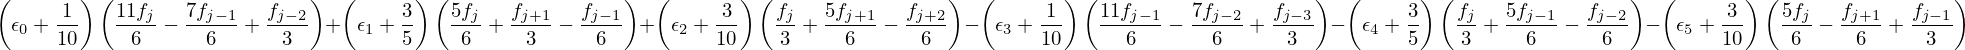

In [4]:
wenol = Data()
epsi = sp.symbols("\\epsilon_:6",real=True)

def linearized_weno_flux () :
  w0 = sp.Rational(1,10) + epsi[0]
  w1 = sp.Rational(6,10) + epsi[1]
  w2 = sp.Rational(3,10) + epsi[2]

  dic = dict([ (ei,epsi[i+3]) for i,ei in enumerate(epsi[:3]) ])
  fjp12_l = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
            + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
            + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  fjm12_l = fjp12_l.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs(dic)

  flux = fjp12_l - fjm12_l
  return flux

wenol.flux = linearized_weno_flux()
display(wenol.flux)

Nous distingons 2 parties dans ce flux :

* $\tilde{z}(\phi)$ qui est la partie linéarire du schéma WENO
* $M(\{\epsilon_i\}_{i=0,\dots,5},\phi)$ la partie non linéaire du schéma WENO

L'anlayse de von Neumann nous permettra d'étudier les différentes contributions de ces termes.

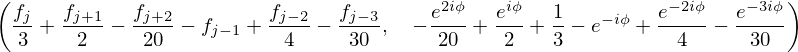

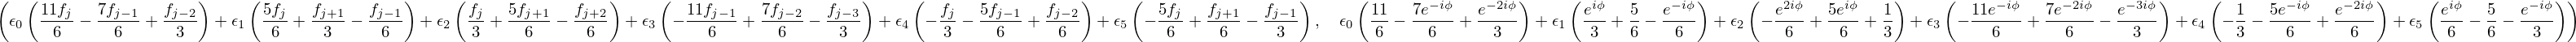

In [5]:
wenol.ztilde = {}
wenol.M = {}
wenol.ztilde["f"] = wenol.flux.expand().subs([(ei,0) for ei in epsi])
wenol.M["f"] = (wenol.flux-wenol.ztilde["f"]).expand().collect(epsi)

wenol.ztilde["vN"] = wenol.ztilde["f"].subs(symbols_to_vonNeumann(f_stencil))
wenol.M["vN"] = wenol.M["f"].subs(symbols_to_vonNeumann(f_stencil))

display((wenol.ztilde["f"],wenol.ztilde["vN"]))
print()
display((wenol.M["f"],wenol.M["vN"]))

On va vouloir étudier les données $\tilde{z}$ et $M$. Ces variables sont issues de la décomposition de $\lambda^{LW}(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i\}_{i=0,\dots,5},\phi)$ avec $M$ comportant tous les $\{\epsilon_i\}_{i=0,\dots,5}$, et $\tilde{z}$ le reste. La seule étude de $\tilde{z}$ suffit à l'étude de la stabilité linéaire du schéma avec différentes méthodes en temps, c'est-à-dire l'existence d'un nombre $\tilde{\sigma}$ tel le schéma est stable sous la condition CFL suivante :

$$
  \Delta t \leq \tilde{\sigma}\Delta x
$$

> L'étude du schéma WENO linéarisé permet d'affirmer l'existence d'une condition CFL et donc affirmer la stabilité d'un schéma, elle ne permet par contre qu'une évaluation de la CFL (que l'on peut conjecturer comme étant systématiquement plus petite que la CFL du schéma complet).

### 1.2.1 Étude de la non linéarité

$M$ représente la partie non linéaire comportant les $\{\epsilon_i\}_{i\in[0,\dots,5]} = \mathcal{O}(\Delta x^2)$.

In [6]:
wenol.M["func"] = []
wenol.M["data"] = []
for arg in wenol.M["vN"].args:
  fun = sp.lambdify(phi,arg.subs([(ei,1) for ei in epsi]),'numpy')
  wenol.M["func"].append(fun)
  wenol.M["data"].append(fun(data.phi))
wenol.M["data"] = np.array(wenol.M["data"])
del arg,fun

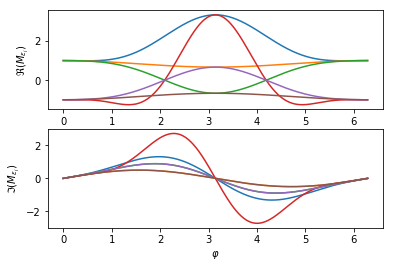

In [7]:
"""
  Plot of each composant in M (one by epsilon_i value)
"""
fig, (ax1, ax2) = plt.subplots(2,1)

for dat in wenol.M["data"]:
  ax1.plot(data.phi,dat.real); ax1.set_xlabel("$\\varphi$"); ax1.set_ylabel("$\\Re(M_{\\epsilon_i})$")
  ax2.plot(data.phi,dat.imag); ax2.set_xlabel("$\\varphi$"); ax2.set_ylabel("$\\Im(M_{\\epsilon_i})$")
plt.show()
del dat,fig,ax1,ax2

En réalité la valeur des différentes composantes de $M$ nous importent peu. Ce qu'il faut remarquer est la forme général de chaque composante, prenons comme exemple la composante $\epsilon_0$ :

$$
  \begin{aligned}
    \Re \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Re}|\epsilon_0| \\
    \Im \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Im}|\epsilon_0|
  \end{aligned}
$$

avec $c_0^{\Re|\Im}$ des constantes positives. Dans [[Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868)], une estimation de $c_0^{\Re}=\frac{10}{3}$ est prise comme exemple. On majore ainsi toutes les composantes en $\epsilon_i$ de $M$, on se retrouve alors avec :

$$
  \begin{aligned}
    \left|\Re\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Re}\max_{0\leq m \leq 5}|\epsilon_m| \\
    \left|\Im\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Im}\max_{0\leq m \leq 5}|\epsilon_m|
  \end{aligned}
$$

avec $\Gamma^{\Re|\Im}$ des constantes postives ne dépendant que de la taille du *stencil* considéré. Cela permet de justifier $M = \mathcal{O}(\Delta x^2)$.

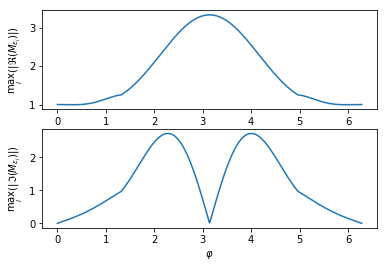

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(data.phi,[ max(np.abs(np.real(wenol.M["data"][:,i]))) for i in range(len(wenol.M["data"][0])) ])
ax1.set_xlabel("$\\varphi$"); ax1.set_ylabel("$\\max_i(|\\Re(M_{\\epsilon_i})|)$")
ax2.plot(data.phi,[ max(np.abs(np.imag(wenol.M["data"][:,i]))) for i in range(len(wenol.M["data"][0])) ])
ax2.set_xlabel("$\\varphi$"); ax2.set_ylabel("$\\max_i(|\\Im(M_{\\epsilon_i})|)$")
plt.show()
del fig,ax1,ax2

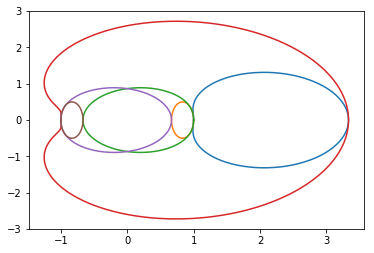

In [9]:
""" just because it's pretty: all composant of M in complex plan """
for dat in wenol.M["data"]:
  plt.plot(dat.real,dat.imag)
plt.show()
del dat

### 1.2.2 La partie linéaire $\tilde{z}$

$\tilde{z}$ est la partie linéaire de $\lambda^{LW}(\phi)$, c'est la partie qui permettra de déterminer la stabilité linéaire puisque l'on a :

$$
  \lambda^{LW}(\phi) = \tilde{z}(\phi) + \mathcal{O}(\Delta x^2)
$$

Donc en prenant $\Delta x$ suffisamment petit, $\lambda^W(\phi) \xrightarrow{\Delta x \to 0} \tilde{z}(\phi)$.

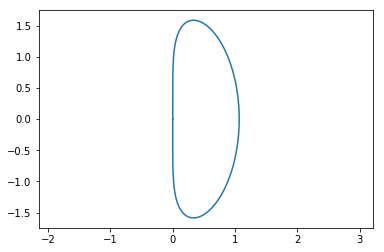

In [10]:
wenol.ztilde["func"] = sp.lambdify(phi,wenol.ztilde["vN"],'numpy')
wenol.ztilde["data"] = wenol.ztilde["func"](data.phi)

plt.plot(*reim(wenol.ztilde["data"]))
plt.axis('equal')
plt.show()

On retrouve la forme caractéristique de haricot présentée dans [[Motamed M. and Macdonald C. B. (2010)](https://doi.org/10.1007/s10915-010-9423-9)].

### 1.2.3 Étude du schéma WENO linéarisé

Le schéma WENO linéarisé, qui correspond à l'approximation des poids à :

$$
    w_i = \gamma_i
$$

c'est-à-dire en considérant que les *indicators of smootheness* valent tous 1, ce qui se justifie avec une fonction suffisamment régulière. On perd *a priori* l'intérêt du schéma WENO, il est donc intéressant d'étudier un peu plus ce schéma.

#### 1.2.3.1 Mesure de l'ordre

On mesure numérique l'ordre à partir du problème suivant :

$$
  \begin{cases}
    \partial_t u + \partial_x u = 0 \\
    u(t=0,x) = \cos(x)
  \end{cases}
$$

![Mesure de l'ordre numérique du schéma WENO linéarisé](img/order_WL.png)

On retrouve bien l'ordre 5 de la méthode WENO classique.

#### 1.2.3.2 Comportement face à une discontinuité

Observons le comportement du schéma WENO linéarisé face à une discontinuité. Nous conservons ici une simple équation de transport linéaire à vitesse 1. La condition initiale est donnée par :

$$
  u(t=0,x) = \begin{cases}
    x \quad &\text{si $x \in [0,1]$}\\
    1 \quad &\text{si $x \in [1,4]$}\\
    0 \quad &\text{sinon}
  \end{cases}
$$

La simulation s'effectuant jusqu'au temps $T_f = 2\pi$ sur le domaine spatial périodique $[0,2\pi]$ avec $N_x = 100$ le nombre de points, et une condition CFL $\Delta t = 0.1\Delta x$. La solution exacte coïncide avec la condition initiale. La discrétisation en temps est un RK SSP(3,3).

![Oscillation du schéma WENO linéarisé en présence d'une discontinuité](misc/trp1d/img/discontinuity_weno_wenol.png)

On remarque que le schéma WENO linéarisé oscille à proximité d'une discontinuité, le schéma WENO classique quant à lui devient plus visqueux à l'aide des poids qui permettent d'effectuer une meilleure interpolation qu'une interpolation polynomiale de degré élevé induisant localement des oscillations.

## 1.3 WENO non linéarisé

Au lieu d'interpréter l'analyse de von Neumann comme une transformée de Fourier du schéma, il est possible d'étudier l'amplification dû à une fonction périodique correspondant à un mode d'excitation particulier. Le calcul fonctionne malgré la non linéarité du schéma et permet d'obtenir un coefficient d'amplification $W(\phi)$ :

$$
  \hat{u}^{n+1} = W(\phi)\hat{u}^n
$$

L'obtention d'une forme simple s'explique par le fait qu'il est toujours possible de mettre en facteur des coefficients $IS_i^\pm$ $(\hat{u}^n)^2$, et donc $(\hat{u}^n)^4$ des poids non normalisés $\alpha_i^\pm$, terme qui se simplifie ensuite lors de la normalisation des poids, ce qui explique leur dépendance uniquement dans la phase $\phi$.

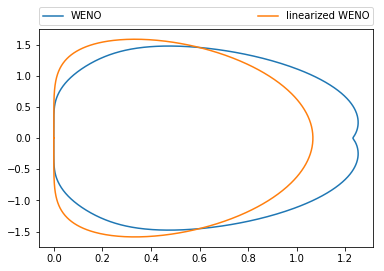

In [19]:
epsilon = sp.symbols("\\epsilon",real=True,positive=True)
weno = Data()

def weno_flux():
  IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
  IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
  IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

  a0 = sp.Rational(1,10)*(1/(epsilon+IS0))**2
  a1 = sp.Rational(6,10)*(1/(epsilon+IS1))**2
  a2 = sp.Rational(3,10)*(1/(epsilon+IS2))**2

  s = a0 + a1 + a2
  w0 = a0 / s
  w1 = a1 / s
  w2 = a2 / s

  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  # on définit fjm12 comme étant fjp12 où on substitut f(j) par f(j-1)
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)
  
  return fjp12-fjm12

weno.flux = weno_flux()
weno.func = sp.lambdify(phi,weno.flux.subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-6)),'numpy')
weno.data = weno.func(data.phi)

plt.plot(*reim(weno.data),label="WENO")
plt.plot(*reim(wenol.ztilde["data"]),label="linearized WENO")
plt.legend(loc=(0.,1.02),ncol=2, mode="expand",borderaxespad=0.)
plt.show()

On remarque une divergence dans les résultats. Une précédente étude avait montré que la CFL du couple RK3-WENO5 était atteinte à la base de l'*œuf* que forme la linéarisation du schéma WENO. La version non linéarisée étant moins large à la base, la CFL semble pouvoir être plus importante.

> Il est intéressant à noter qu'un transport pur s'exprime avec l'axe imaginaire, la partie réelle traduit un phénomène de diffusion. On remarque que le schéma WENO linéarisé est donc moins diffusif que sa version standard. Ceci s'explique par la construction du schéma WENO qui par le biais de ses poids, diffuse à l'approche d'une discontinuité au lieu d'osciller. Une confirmation de se résultat a été apporté numériquement par des tests sur le schémas WENO linéarisé, celui-ci oscille légèrement à l'approche d'une discontinuité au lieu de diffuser. Diffusion observée lors de la comparaison des deux schémas en temps long.

## WENO non linéarisé modifié

Il existe différentes méthodes de calcul des poids du schéma WENO, qui ont été listées et comparées [ici](https://github.com/wme7/WENO5-X) par Manuel A. Diaz. Nous étudirons ici leur différents coefficients d'amplification.

La différence réside uniquement dans l'estimation des poids, les indicateurs de continuité $\beta_i$ ainsi que les coefficients $\gamma_i$ restent identique.

| Méthode     | Calcul des poids $w_i$ | Parmètres |
|-------------|------------------------|-----------|
| **WENO-JS** | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-6}$                              |
| **WENO-Z**  | $$\begin{aligned}\alpha_i &\gets \gamma_i\left(1+\frac{\tau_5}{\epsilon + \beta_i}\right) \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-40}$, $\tau_5 = |\beta_0-\beta_2|$ |
| **WENO-M**  | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \\ g_i &\gets w_i\left(\frac{\gamma_i + \gamma_i^2 - 3w_i\gamma_i + w_i^2}{\gamma_i^2+w_i(1-2\gamma_i)}\right) \\ w_i &\gets \frac{g_i}{\sum g_k} \end{aligned}$$ | $\epsilon = 10^{-6}$ |


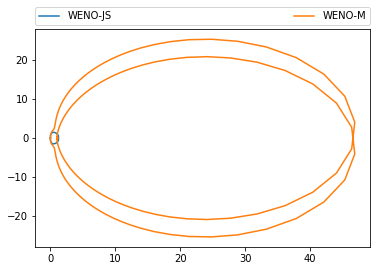

In [68]:
wenoZ = Data()
wenoM = Data()

def wenoZ_flux():
  IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
  IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
  IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

  tau = sp.Abs(IS0-IS2)
  
  a0 = sp.Rational(1,10)*(1+tau/(epsilon+IS0))
  a1 = sp.Rational(6,10)*(1+tau/(epsilon+IS1))
  a2 = sp.Rational(3,10)*(1+tau/(epsilon+IS2))

  s = a0 + a1 + a2
  w0 = a0 / s
  w1 = a1 / s
  w2 = a2 / s

  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  # on définit fjm12 comme étant fjp12 où on substitut f(j) par f(j-1)
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)
  
  return fjp12-fjm12

wenoZ.flux = wenoZ_flux()
wenoZ.func = sp.lambdify(phi,wenoZ.flux.subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-6)),'numpy')
wenoZ.data = wenoZ.func(data.phi)

def wenoM_flux():
  IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
  IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
  IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

  gam0 = sp.Rational(1,10)
  gam1 = sp.Rational(6,10)
  gam2 = sp.Rational(3,10)
  a0 = gam0/(epsilon+IS0)**2
  a1 = gam1/(epsilon+IS1)**2
  a2 = gam2/(epsilon+IS2)**2

  s = a0 + a1 + a2
  w0 = a0 / s
  w1 = a1 / s
  w2 = a2 / s
  
  def g(gam,w):
    return w*(gam+gam**2-3*gam*w+w**2)/(gam**2+w*(1-2*gam))
    
  g0 = g(gam0,w0)
  g1 = g(gam1,w1)
  g2 = g(gam2,w2)
  
  s = g0 + g1 + g2
  w0 = g0 / s
  w1 = g1 / s
  w2 = g2 / s

  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  # on définit fjm12 comme étant fjp12 où on substitut f(j) par f(j-1)
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)
  
  return fjp12-fjm12

wenoM.flux = wenoM_flux()
wenoM.func = sp.lambdify(phi,wenoM.flux.subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-6)),'numpy')
wenoM.data = wenoM.func(data.phi)

plt.plot(*reim(weno.data),label="WENO-JS")
#plt.plot(*reim(wenoZ.data),label="WENO-Z")
#plt.plot(*reim(wenoZ2.data),label="WENO-Z2")
plt.plot(*reim(wenoM.data),label="WENO-M")
#plt.plot(*reim(wenol.ztilde["data"]),label="linearized WENO")
plt.legend(loc=(0.,1.02),ncol=2, mode="expand",borderaxespad=0.)
plt.show()

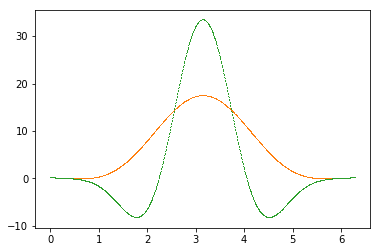

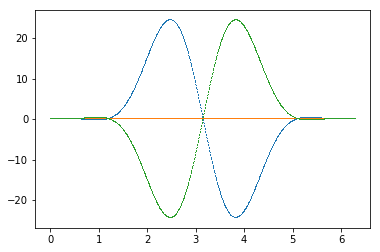

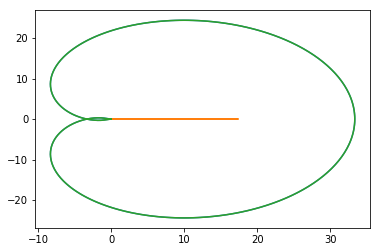

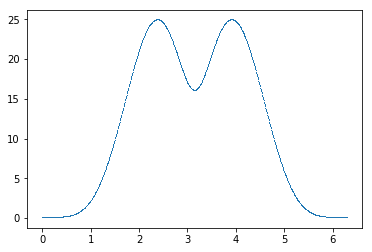

In [40]:
IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2
is0 = sp.lambdify(phi,IS0.subs(symbols_to_vonNeumann(f_stencil)),'numpy')(data.phi)
is1 = sp.lambdify(phi,IS1.subs(symbols_to_vonNeumann(f_stencil)),'numpy')(data.phi)
is2 = sp.lambdify(phi,IS2.subs(symbols_to_vonNeumann(f_stencil)),'numpy')(data.phi)

plt.plot(data.phi,reim(is0)[0],",")
plt.plot(data.phi,reim(is1)[0],",")
plt.plot(data.phi,reim(is2)[0],",")
plt.show()
plt.plot(data.phi,reim(is0)[1],",")
plt.plot(data.phi,reim(is1)[1],",")
plt.plot(data.phi,reim(is2)[1],",")
plt.show()
plt.plot(*reim(is0))
plt.plot(*reim(is1))
plt.plot(*reim(is2))
plt.show()
plt.plot(data.phi,np.abs(is0-is1),",")
plt.show()

In [ ]:
wls = (1,sp.Rational(3,4),sp.Rational(1,2))

bweno.funcwl = [ sp.lambdify(phi,bweno_expr(wl).subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-8)),'numpy') for wl in wls ]
bweno.datawl = [ f(data.phi) for f in bweno.funcwl ]
bweno.reimwl = [ reim(dat) for dat in bweno.datawl ]

fig, ax = plt.subplots(nrows=len(wls),ncols=3,figsize=(14,14))

for i,wl in enumerate(wls) :
  ax[i][0].plot(*bweno.reimwl[i],label="BWENO")
  ax[i][0].plot(*reim(weno.data),':',label="WENO")
  ax[i][0].plot(*reim(wenol.data_z),':',label="linearized WENO")
  ax[i][0].set_ylabel("$w^L = {}$".format(wl))
  
  ax[i][1].plot(data.phi,bweno.reimwl[i][0],label="BWENO")
  ax[i][1].plot(data.phi,reim(weno.data)[0],':',label="WENO")
  ax[i][1].plot(data.phi,reim(wenol.data_z)[0],':',label="linearized WENO")
  
  ax[i][2].plot(data.phi,bweno.reimwl[i][1],label="BWENO")
  ax[i][2].plot(data.phi,reim(weno.data)[1],':',label="WENO")
  ax[i][2].plot(data.phi,reim(wenol.data_z)[1],':',label="linearized WENO")

ax[0][1].title.set_text("$\\Re(W(\phi))$")
ax[0][2].title.set_text("$\\Im(W(\phi))$")
handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc=(0.,0.04),ncol=len(wls),mode="expand",borderaxespad=0.)
plt.show()

# Schéma BWENO

Dans 

In [18]:
%whos

Variable                Type             Data/Info
--------------------------------------------------
Data                    type             <class '__main__.Data'>
I                       ImaginaryUnit    I
data                    Data             <__main__.Data object at 0x115762f28>
display                 function         <function display at 0x10bc91bf8>
dt                      Symbol           \Delta t
dv                      Symbol           \Delta v
dx                      Symbol           \Delta x
epsi                    tuple            n=6
epsilon                 Symbol           \epsilon
f                       function         <function f at 0x11597e2f0>
f_stencil               dict             n=7
linearized_weno_flux    function         <function linearized_weno_flux at 0x11597e510>
np                      module           <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
phi                     Symbol           \phi
plot                    function         <func